# Stain-free leukocyte prediction

## Package imports

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
# %load common_.py
import sys
sys.path.append("../")
from common import *

In [8]:
import fcsparser
from ehv import feature_comparison, core
import flowutils
import shap
shap.initjs()

In [9]:
import sklearn.base
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize, scale, minmax_scale, LabelEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [10]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.pipeline import make_pipeline as imb_make_pipeline

In [11]:
from multiprocessing import Pool
from scipy.stats import spearmanr
import pickle
import hiplot

## Data import

Feature values from SCIP and IDEAS are imported. In total we import 133354 features.

In [16]:
data_dir = Path(os.environ["HOME"]) / "scratch/data/vsc/datasets/wbc/scip/202204271347/"

In [ ]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/wbc/scip/202204271347/"

In [17]:
df_scip = pq.read_table(data_dir / "features.parquet").to_pandas()

cat_type = CategoricalDtype(
    categories=sorted(df_scip["meta_group"].astype(int).unique()), ordered=True)
df_scip["meta_group"] = df_scip["meta_group"].astype(int).astype(cat_type)

cat_type = CategoricalDtype(
    categories=sorted(df_scip["meta_part"].astype(int).unique()), ordered=True)
df_scip["meta_part"] = df_scip["meta_part"].astype(int).astype(cat_type)

df_scip = df_scip.set_index(["meta_group", "meta_part", "meta_fix", "meta_object_number"])

df_scip = df_scip[numpy.load(
    data_dir / "indices/columns.npy", allow_pickle=True)]
df_scip = df_scip.loc[numpy.load(
    data_dir / "indices/index.npy", allow_pickle=True)]

df_scip["meta_label"] = pandas.Categorical(df_scip["meta_label"], ordered=True)

df_scip.shape

(233262, 2200)

In [18]:
df_scip["meta_label"].value_counts()

CD15 + Neutrophils    139710
CD4 T cells            34460
CD8 T cell             15009
unknown                14632
CD19 pos B cells        9035
CD56+ NK Cells          6798
CD14+ Monocyte          4800
NK T cells              4727
Eosinophils             4091
Name: meta_label, dtype: int64

In [19]:
df = df_scip

In [20]:
df.shape

(233262, 2200)

## Continue with events assigned to cell states

I filter out the events falling between manual gates. This is only a small amount of events

In [21]:
df = df.loc[df["meta_label"] != "unknown"].copy()
df.shape

(218630, 2200)

In [22]:
df["meta_label"] = df["meta_label"].astype("category")

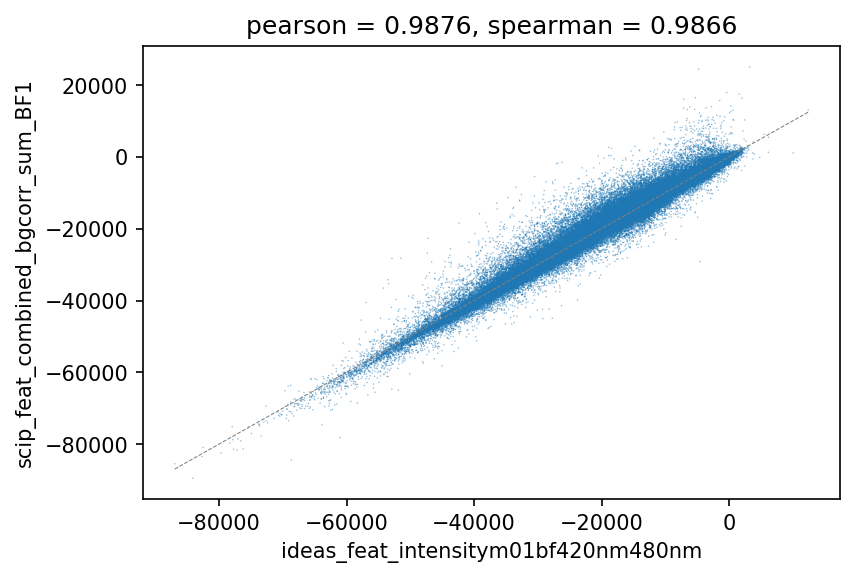

In [62]:
feature_comparison.compare_features(df, "ideas_feat_intensitym01bf420nm480nm", "scip_feat_combined_bgcorr_sum_BF1")

In [67]:
enc = LabelEncoder().fit(df["meta_label"])
y = enc.transform(df["meta_label"])

In [54]:
%%time
scoring = ('balanced_accuracy', 'f1_macro', 'f1_micro', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro')
grid = GridSearchCV(
    model_svc,
    {
        "svc__C": [0.1, 0.5, 1, 1.5, 2, 2.5]
    },
    refit=False,
    n_jobs=30,
    cv=5,
    scoring=scoring,
    verbose=1,
    return_train_score=True
).fit(
    numpy.ascontiguousarray(Xs_train.values),
    y_train
)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

AttributeError: 'FacetGrid' object has no attribute 'cv_results_'

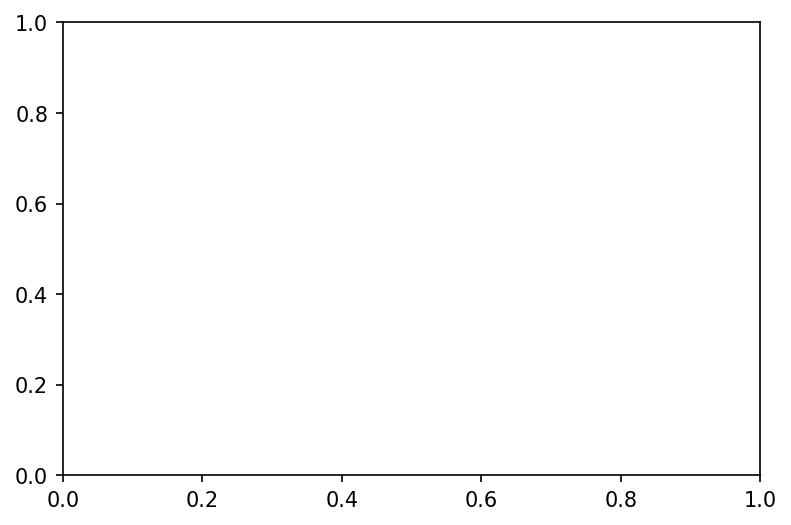

In [55]:
fig, ax = plt.subplots(dpi=150)
ax.errorbar(grid.cv_results_["param_svc__C"], grid.cv_results_["mean_test_balanced_accuracy"], yerr=grid.cv_results_["std_test_balanced_accuracy"], label="test")
ax.errorbar(grid.cv_results_["param_svc__C"], grid.cv_results_["mean_train_balanced_accuracy"], yerr=grid.cv_results_["std_train_balanced_accuracy"], label="train")

First on IDEAS features.

In [60]:
%%time
model_svc_i = model_svc.fit(Xi_train, y_train)

CPU times: user 38.8 s, sys: 429 ms, total: 39.2 s
Wall time: 39.5 s


In [61]:
%%time
preds_i = model_svc_i.predict(Xi_test)
balanced_accuracy_score(y_test, preds_i)

CPU times: user 4min 57s, sys: 10.8 ms, total: 4min 57s
Wall time: 4min 58s


0.7402223360180239

The balanced accuracy has a fairly good value. The confusion matrix below gives us more insight into where the model struggles. In the confusion matrix we want to see ideally a high value on the diagonal. On the diagonal the events are counted for which the prediction of the model agrees with the actual ground truth label. Off-diagonal counts indicate wrong predictions by the model, this indicates the model's _confusion_. Note that the matrix is normalized per row.

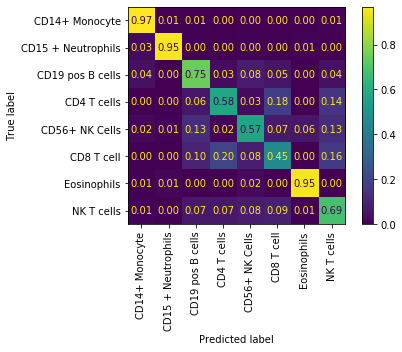

In [70]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_i, display_labels=enc.classes_, normalize='true', xticks_rotation="vertical", values_format=".2f")

In [63]:
%%time
model_svc_s = model_svc.fit(Xs_train, y_train)

CPU times: user 1min 31s, sys: 433 ms, total: 1min 32s
Wall time: 1min 32s


In [67]:
%%time
preds_s = model_svc_s.predict(Xs_test)
balanced_accuracy_score(y_test, preds_s)

0.7545157650611263

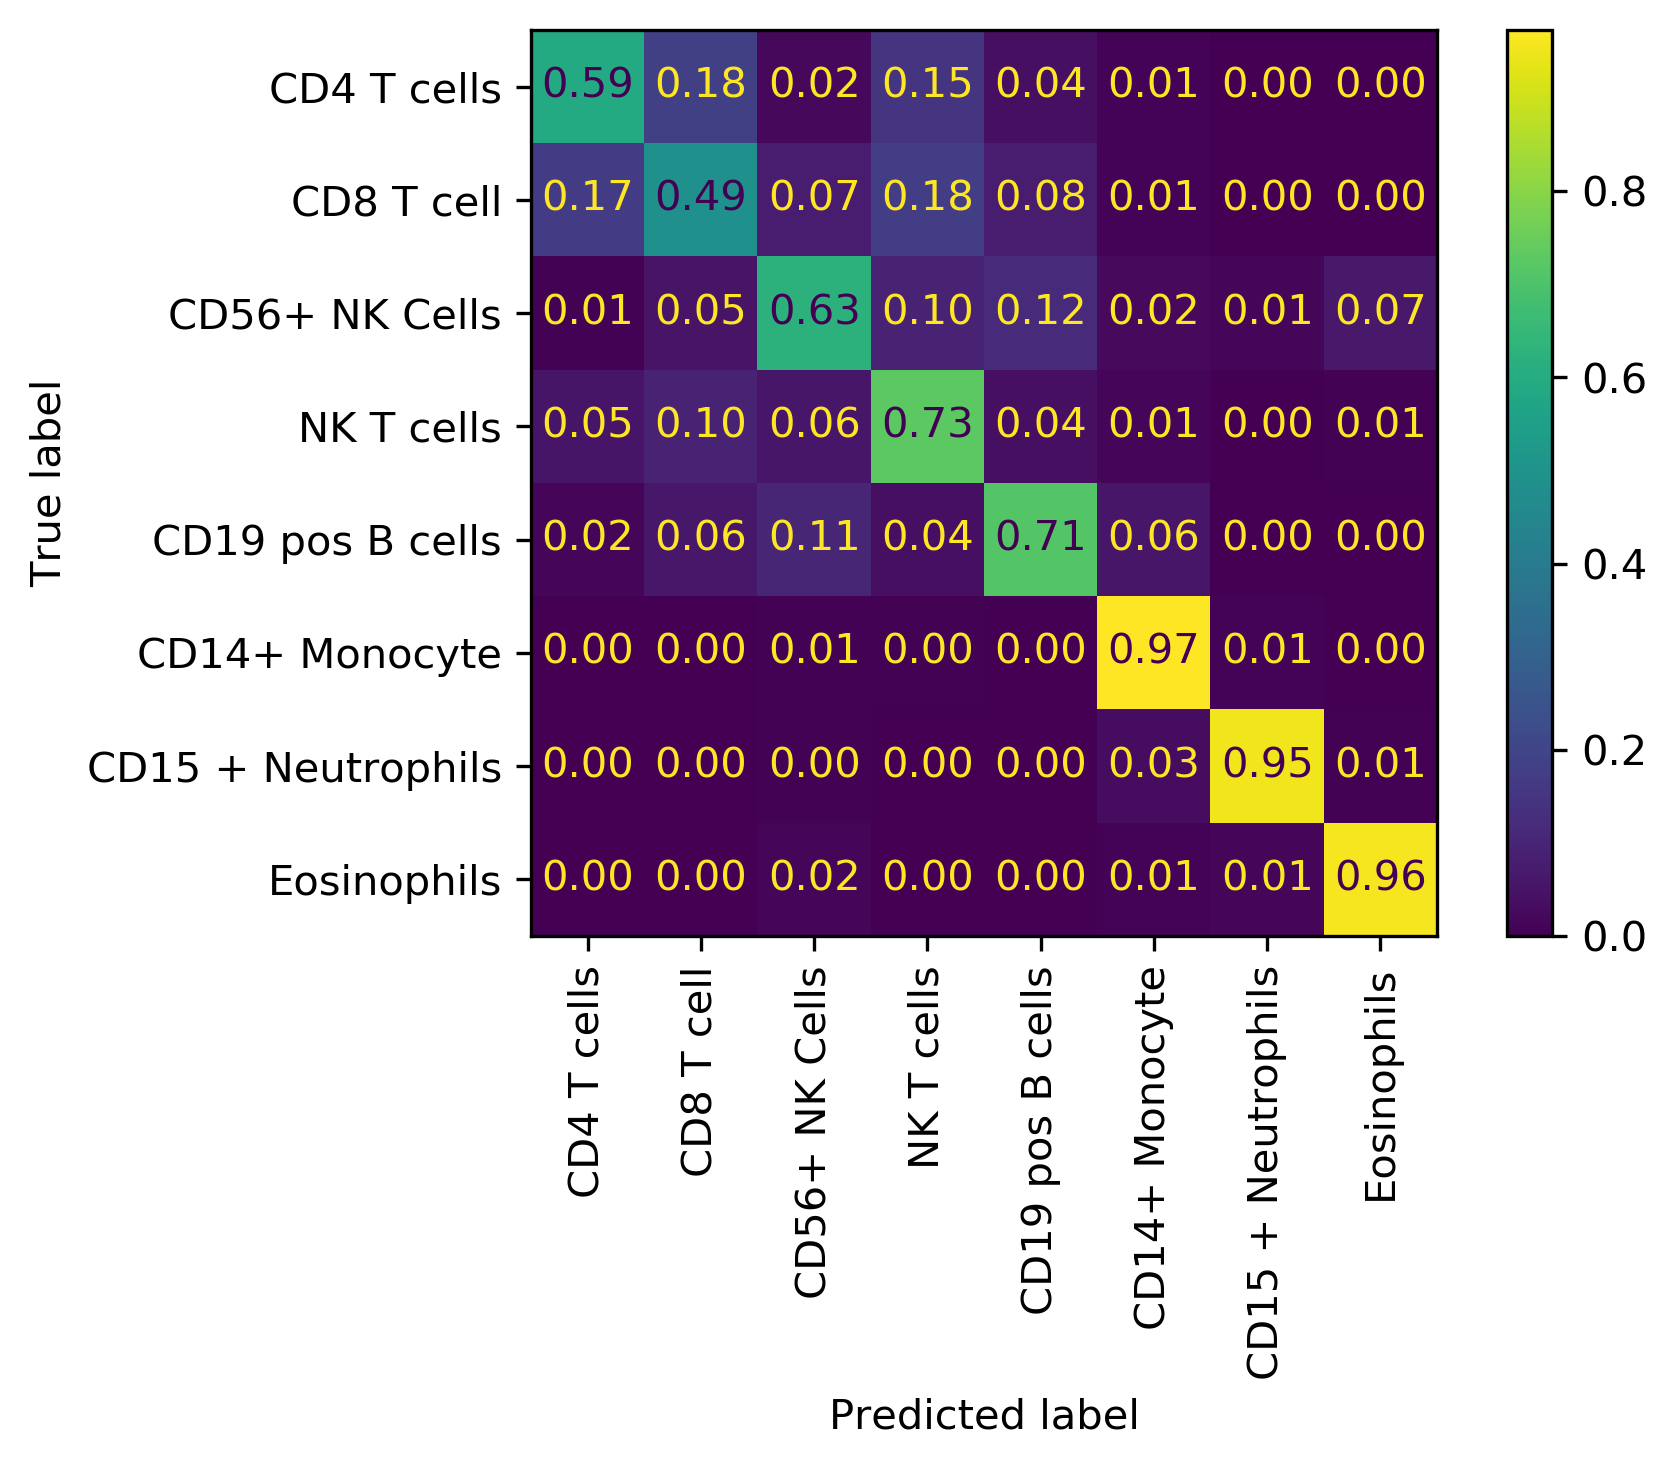

In [80]:
fig, ax = plt.subplots(dpi=300)
ConfusionMatrixDisplay.from_predictions(
    y_test, preds_s,
    labels=[3, 5, 4, 7, 2, 0, 1, 6],
    display_labels=enc.classes_[[3, 5, 4, 7, 2, 0, 1, 6]],
    normalize='true', xticks_rotation="vertical", values_format=".2f",
    ax=ax
)

## Classification and feature analysis using an Extreme Gradient Boosting classifier

### Tuning hyper parameters

We inspect the results from recursive successive halving hyper parameter optimization

In [34]:
def rsh_plot(grid):
    results = pandas.DataFrame(grid.cv_results_)
    results["params_str"] = results.params.apply(lambda foo: str({k:v for k,v in foo.items() if k != "xgbclassifier__n_estimators"}))
    
    results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
    mean_scores = results.pivot(
        index="iter", columns="params_str", values="mean_test_score"
    )
    
    fig, ax = plt.subplots(dpi=150)
    
    twin_res = ax.twinx()
    twin_cand = ax.twinx()
    twin_cand.spines.right.set_position(("axes", 1.2))
    
    p1, = twin_res.plot(
        numpy.arange(grid.n_iterations_), 
        [grid.n_resources_[i] for i in range(grid.n_iterations_)], 
        "--", alpha=0.7, linewidth=1, color="#E09F3E", zorder=-1)
    p2, = twin_cand.plot(
        numpy.arange(grid.n_iterations_), 
        [grid.n_candidates_[i] for i in range(grid.n_iterations_)], 
        "--", alpha=0.7, linewidth=1, color="#004E98", zorder=-2)
    
    mean_scores.plot(legend=False, alpha=0.6, ax=ax, color="#E15554", zorder=2)
    
    twin_res.yaxis.label.set_color(p1.get_color())
    twin_cand.yaxis.label.set_color(p2.get_color())

    ax.set_xticks(range(grid.n_iterations_))
    ax.set_title("Scores of candidates over iterations")
    ax.set_ylabel("balanced accuracy", fontsize=10)
    ax.set_xlabel("iterations", fontsize=10)
    twin_res.set_ylabel("Number of resources")
    twin_cand.set_ylabel("Number of candidates")
    twin_res.tick_params(axis='y', colors=p1.get_color())
    twin_cand.tick_params(axis='y', colors=p2.get_color())
    
    seaborn.despine(fig, right=False, trim=True)
    
def hip_plot(grid):
    df = pandas.DataFrame(grid.cv_results_["params"])
    df["mean_test_balanced_accuracy"] = grid.cv_results_["mean_test_score"]
    df["mean_train_balanced_accuracy"] = grid.cv_results_["mean_train_score"]
    df["std_test_balanced_accuracy"] = grid.cv_results_["std_test_score"]
    df["std_train_balanced_accuracy"] = grid.cv_results_["std_train_score"]

    hiplot.Experiment.from_iterable(df.to_dict(orient="records")).display()

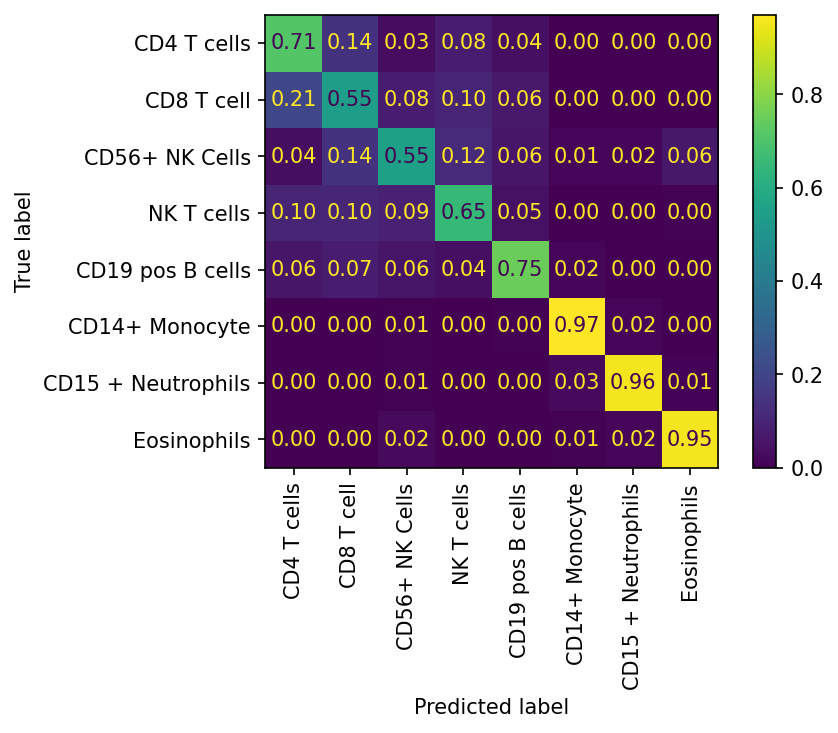

In [109]:
fig, ax = plt.subplots(dpi=150)
ConfusionMatrixDisplay.from_predictions(
    y_test, preds, 
    labels=[3, 5, 4, 7, 2, 0, 1, 6],
    display_labels=enc.classes_[[3, 5, 4, 7, 2, 0, 1, 6]],
    normalize='true', xticks_rotation="vertical", values_format=".2f",
    ax=ax
)
# plt.savefig("xgb_pbmc_confmat.png", bbox_inches="tight")

In [194]:
with open(data_dir / f"hpo/rsh_cyto.pickle", "rb") as fh:
    grid4 = pickle.load(fh)

In [201]:
grid4["test_balanced_accuracy"], grid4["train_balanced_accuracy"]

(array([0.80788547, 0.8060712 , 0.80859586, 0.8139985 , 0.81147393]),
 array([0.89958019, 0.89560127, 0.89756321, 0.93514669, 0.8964616 ]))

In [206]:
grid4["estimator"][0].best_params_

{'xgbclassifier__subsample': 0.9,
 'xgbclassifier__n_estimators': 150,
 'xgbclassifier__min_child_weight': 27,
 'xgbclassifier__max_depth': 4,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__gamma': 2,
 'xgbclassifier__colsample_bytree': 0.8}

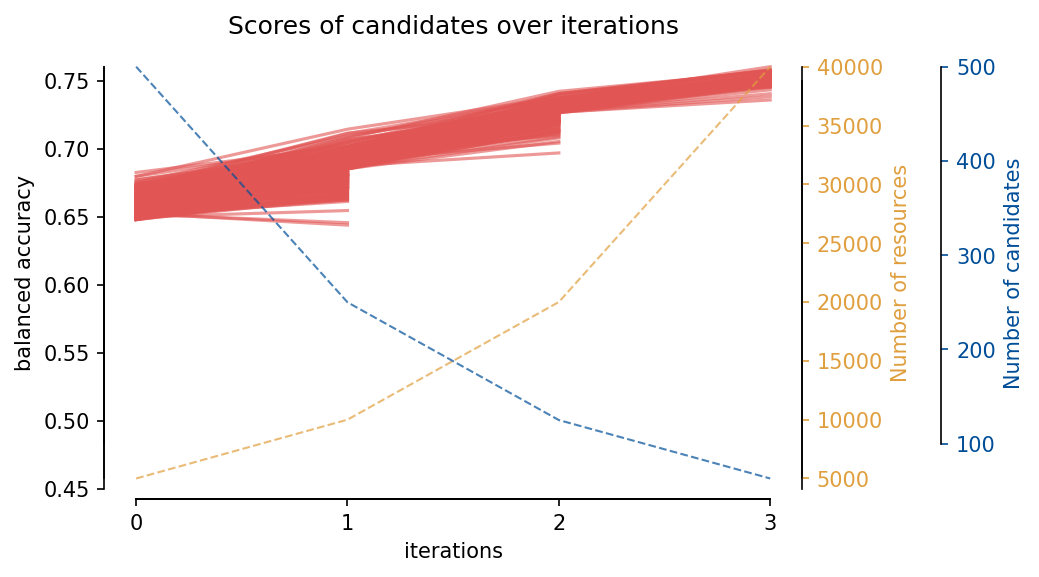

In [197]:
rsh_plot(grid4["estimator"][0])

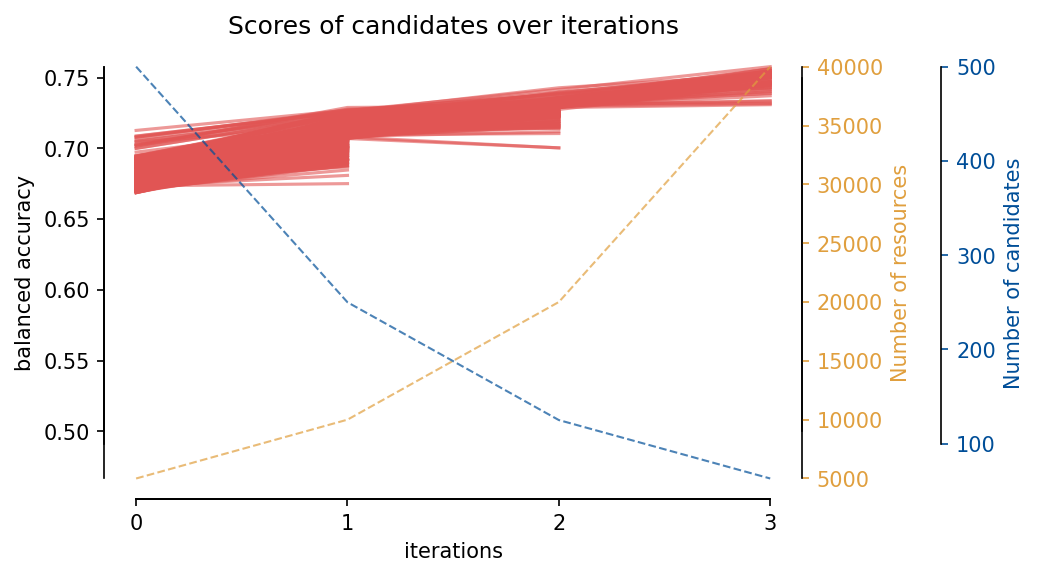

In [198]:
rsh_plot(grid4["estimator"][1])

In [209]:
grid4["estimator"][0].predict(df.filter(regex="(BF1|BF2|SSC)$").iloc[:100])

array([6, 0, 0, 1, 0, 0, 1, 1, 0, 0, 4, 0, 0, 1, 0, 0, 0, 3, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 4, 0, 0, 1, 1, 0, 0, 0, 4, 1, 4, 1, 6, 0,
       4, 0, 0, 1, 0, 1, 0, 0, 5, 0, 0, 0, 1, 4, 4, 4, 1, 4, 0, 1, 1, 0,
       4, 1, 1, 1, 4, 1, 4, 1, 4, 1, 0, 0, 0, 4, 0, 4, 0, 3, 4, 0, 6, 5,
       0, 1, 0, 1, 4, 4, 0, 0, 0, 0, 4, 0], dtype=int32)

### Interpreting the Extreme Gradient Boosting classifier

#### Feature importances of the decision trees

One way of interpreting the model is by looking at the features importances. Decision tree-based classifiers are constructed by iteratively splitting up the dataset based on an optimal value of a specific feature. This process continues until pure _leaves_ are obtained which contain only instances from one class. Througout the training process the algorithm records how many times a feature is used for splitting the set. A feature that is used often will have a high importance score.

In the table below, we can see the top 10 most important features used by the XGB model to predict the infection state based on the BF1, SSC and DAPI signals. We can see that these are mainly DAPI features. This is already an interesting observation, but it does not give us much further insight. For example, we don't know whether these features are equally important for classifying all infection states. It also does not indicate what specific values of a feature might lead to a certain state prediction.

To try to answer these questions, I look at the SHAP algorithm in the next section.

In [99]:
model = model_xgb_s.named_steps["xgbclassifier"]

In [100]:
s = numpy.argsort(model.feature_importances_)
pandas.DataFrame(dict(feature = Xs.columns[s[-10:][::-1]], importance=model.feature_importances_[s[-10:][::-1]]))

,feature,importance
0,scip_feat_bgcorr_edge_mad_SSC,0.083615
1,scip_feat_edge_mad_SSC,0.054030
2,scip_feat_moments_central-2-2_BF2,0.049699
3,scip_feat_bgcorr_edge_median_SSC,0.024519
4,scip_feat_edge_sum_SSC,0.019041
5,scip_feat_bgcorr_edge_upper_quartile_SSC,0.017917
6,scip_feat_sobel_std_SSC,0.017707
7,scip_feat_feret_diameter_max_BF2,0.016155
8,scip_feat_combined_upper_quartile_SSC,0.015639
9,scip_feat_combined_bgcorr_edge_sum_BF1,0.014957


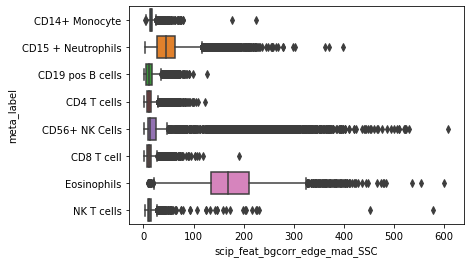

In [102]:
seaborn.boxplot(
    data=df_train,
    x=Xs.columns[s[-10:][::-1][0]],
    y="meta_label"
)

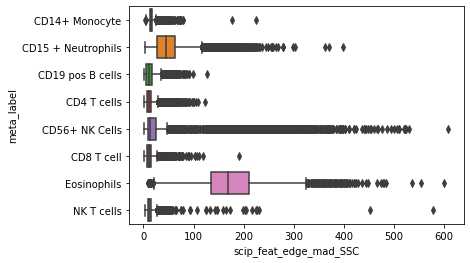

In [103]:
seaborn.boxplot(
    data=df_train,
    x=Xs.columns[s[-10:][::-1][1]],
    y="meta_label",
    hue_order=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"]
)

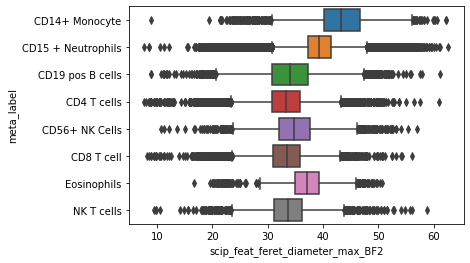

In [104]:
seaborn.boxplot(
    data=df_train,
    x=Xs.columns[s[-10:][::-1][7]],
    y="meta_label",
    hue_order=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"]
)

#### SHAP analysis to identify features explaining cell states

In [ ]:
# we only look at events that were correctly predicted by the model
Xs_correct = Xs_test[preds == y_test]

In [ ]:
numpy.random.seed(0)
explainer = shap.TreeExplainer(model)
shap_values = explainer(Xs_correct)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


To understand the SHAP algorithm, we first have to understand how a gradient boosting classifier works. In short, $N$ different decision trees are trained to predict a class from the input features. When a prediction needs to be made, each tree produces its prediction in the form of a vector containing negative and positive ones. In this setting, each output vector will contain 4 numbers (= amount of states) of which only one will be positive (= the state this decision tree thinks the input belongs to). The vectors from all the trees are then added using a weighted sum. This produces one vector containing for numbers. The class with the highest number is the one predicted by the gradient boosting model.

The SHAP algorithm then analyzes the trees in the gradient boosting model, and tries to attribute how much each feature with it's specific value contributed to the numbers that are output by the model. 

This way the SHAP analysis is similar to the feature importance above, but it gives us a much more detailed look into feature importances: for every value of every feature of every instance we get a particular importance score. 

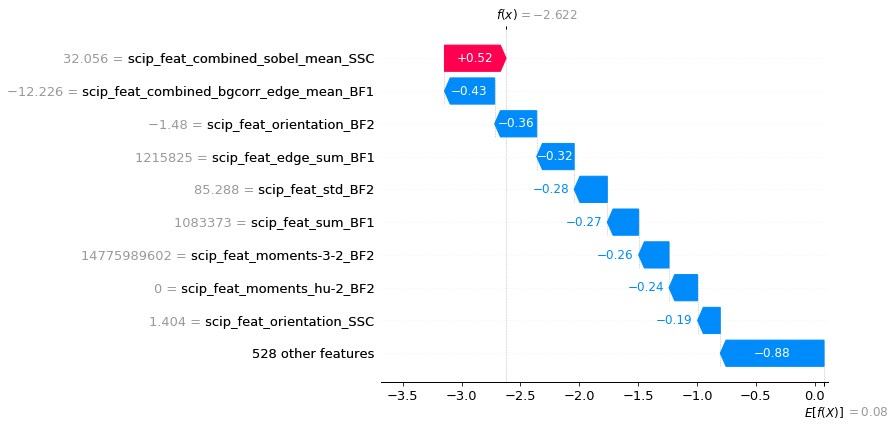

In [ ]:
shap.plots.waterfall(shap_values[0, :, enc.transform(["Eosinophils"])[0]])

##### MCP-/PSBA+ events

Above, we saw an explanation for one event. Below, we see the beeswarm plot, which summarizes the contributions of the features for all events in the dataset. This is still for the MCP-/PSBA+ class. 

Each dot on the plot corresponds to one event. The color of the dot indicates the value of the feature for an event (low to high, blue to red). The rows are ordered according to average importance over the dataset. If a dot is to the left of the center-line, the feature contributes negatively to the event being classified in the MCP-/PSBA+ state. If it is on the right, it contributes positively (= making it more likely that an event would be classified as this state).

On the first row, we again find the MAD of the edge of cell in the BF channel. We can see that on average high values of this feature contribute positively to events being classified as MCP-/PSBA+. On the second row, we find the maximum value of the sobel map of the DAPI channel. The sobel map computes the gradient of neighbouring pixels in the image. A high maximum value of the sobel map means that the image contains a set of neighbouring pixels that have a large difference in intensity. If this feature is low, the neighbouring pixels are more uniform and don't change rapidly. Because the red dots are mainly to the left of the center line, we can derive that high values of this feature contribute negatively to an event being classified as MCP-/PSBA+. Events with a more uniform DAPI signal (= blue dots to the right of the center line) are more likely to be classified as MCP-/PSBA+ cells.

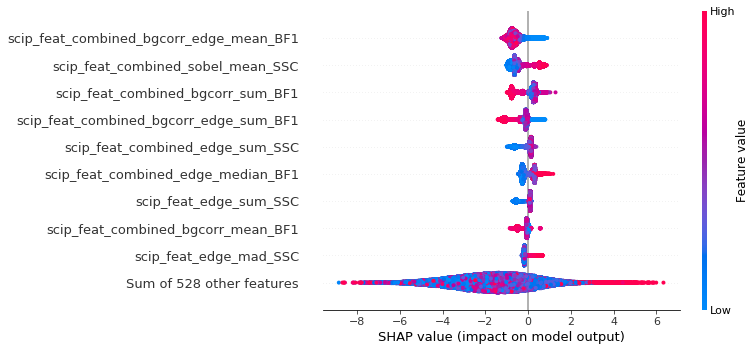

In [ ]:
label = enc.transform(["Eosinophils"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

A final new SHAP plot shown below, zooms in on one specific feature. It shows the feature's contribution to the prediction in function of the feature value. In the plot we look at the maximum sobel value in the DAPI channel. Each dot corresponds again to one event. This plot allows us to see patterns within the range of values that a feature can assume. 

On the X-axis we see the possible values of the feature in the dataset, and in gray the distribution of it. On the Y-axis, we see the contribution of the feature to the MCP-/PSBA+ state prediction. Ignoring the color of the dots for now, we can derive that as the maximum sobel value of the DAPI channel increases beyond approximately 150 the feature starts to contribute negatively to the MCP-/PSBA+ state. Events with a value less then 150 are thus more likely to be classified as MCP-/PSBA+.

A second aspect is the color. This color denotes the value of another feature, in this case kurtosis of the distribution of intensities in the DAPI channel. This feature interacts strongly with the maximum sobel value in the DAPI channel. For example, we can see that values that have a maximum sobel of less than 150 and a high kurtosis value have a smaller positive contribution towards MCP-/PSBA+ than the events with a low kurtosis value. So in biological terms this means that events with a uniform DAPI signal and a narrow distribution of DAPI intensities are more likely to be MCP-/PSBA+ events than those with a wide distribution of DAPI intensities. 

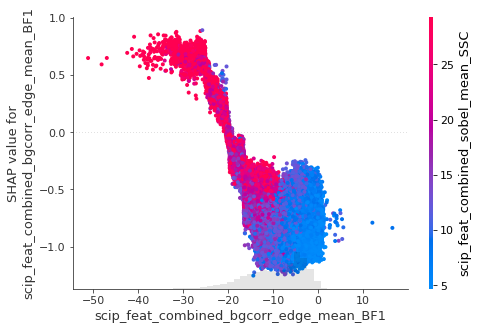

In [ ]:
label = enc.transform(["Eosinophils"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_combined_bgcorr_edge_mean_BF1", label], color=shap_values[:, :, label])

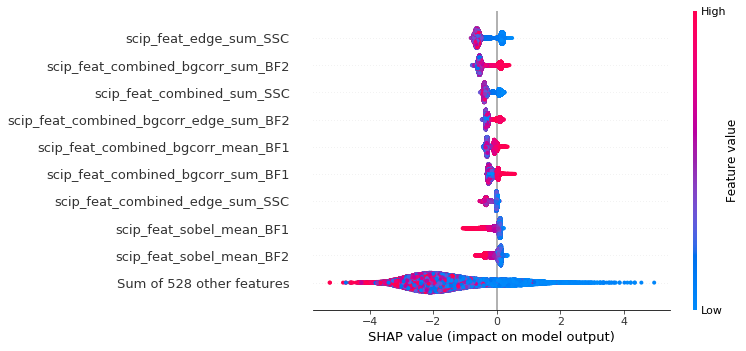

In [ ]:
label = enc.transform(["CD8 T cell"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

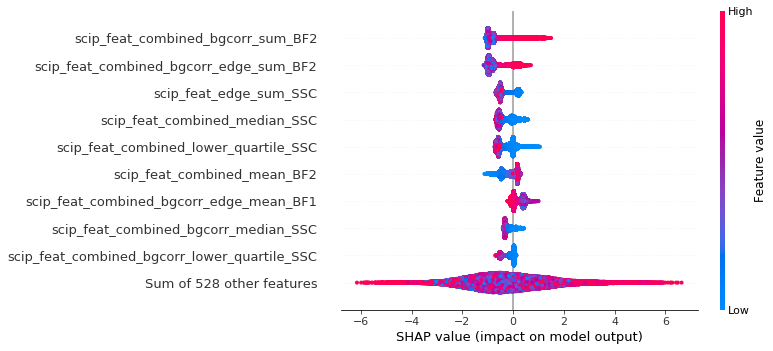

In [ ]:
label = enc.transform(["CD4 T cells"])[0]
shap.plots.beeswarm(shap_values[:, :, label])